# Dataset Generation Notebook: Synthetic Dot Patterns

**Objective:**  
Generate a synthetic dataset of dot patterns for numerosity-based categorization. The dataset will be split into training, validation and test sets, then saved to disk.  

**Reproducibility:**  
A fixed random seed is set for Python's random, NumPy and PyTorch to ensure that every run produces identical results.


# Environment Setup

In [1]:
!pip install torch torchvision numpy opencv-python matplotlib -q

import torch
import numpy as np
import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior for CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42 for reproducibility.")

Random seed set to 42 for reproducibility.


# Define the Dataset Class

In [3]:
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split

In [4]:
label_names = {0: "Few", 1: "Medium", 2: "Many"}

In [5]:
class DotPatternDataset(Dataset):
    def __init__(self, num_samples=5000, image_size=128, categories=(5, 15)):
        """
        Args:
            num_samples (int): Number of images to generate.
            image_size (int): Height and width of the square images.
            categories (tuple): Tuple defining thresholds for categorization.
                                * First value: Maximum dot count for "Few".
                                * Second value: Maximum dot count for "Medium".
                                Dot counts above the second value are categorized as "Many".
        """
        self.num_samples = num_samples
        self.image_size = image_size
        self.categories = categories
        self.data, self.labels = self.generate_dataset()

    def generate_dataset(self):
        data = []
        labels = []
        for _ in range(self.num_samples):
            img, label = self.generate_image()
            data.append(img)
            labels.append(label)
        # Stack images into a tensor and convert labels to tensor.
        return torch.stack(data), torch.tensor(labels, dtype=torch.long)

    def generate_image(self):
        # Create a blank grayscale image.
        img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        # Randomly decide the number of dots (1 to 30).
        num_dots = random.randint(1, 30)
        # Draw each dot with random position and size.
        for _ in range(num_dots):
            x = random.randint(5, self.image_size - 5)
            y = random.randint(5, self.image_size - 5)
            size = random.randint(3, 12)
            img = cv2.circle(img, (x, y), size, (255,), -1)
        # Convert image to tensor, add a channel dimension, and normalize to [0,1].
        img = torch.tensor(img).unsqueeze(0) / 255.0
        # Categorize based on dot count.
        label = self.categorize(num_dots)
        return img, label

    def categorize(self, num_dots):
        if num_dots <= self.categories[0]:
            return 0  # Few
        elif num_dots <= self.categories[1]:
            return 1  # Medium
        else:
            return 2  # Many

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Split Dataset into Training & Testing Sets

In [6]:
dataset = DotPatternDataset(num_samples=5000, image_size=128)

In [7]:
total_samples = len(dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Total Samples: {total_samples}")
print(f"Train Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")

Total Samples: 5000
Train Samples: 3500
Validation Samples: 750
Test Samples: 750


# Save the Datasets for Reproducibilty

In [8]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(val_dataset, "val_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

print("Datasets saved to disk as 'train_dataset.pt', 'val_dataset.pt', and 'test_dataset.pt'.")

Datasets saved to disk as 'train_dataset.pt', 'val_dataset.pt', and 'test_dataset.pt'.


# Visualize Sample Images

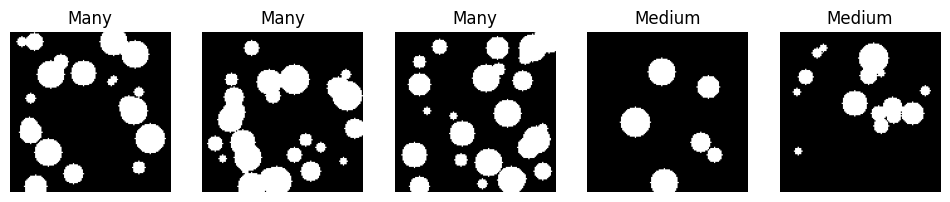

In [9]:
plt.figure(figsize=(12, 4))
for i in range(5):
    img, label = dataset[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    # Use the label_names dictionary for descriptive names.
    plt.title(f'{label_names[label.item()]}')
    plt.axis('off')
plt.show()